In [58]:
try:
    import ase.io
    print("successfully imported ase")
except ImportError:
    !! pip install ase --user --upgrade
    print("completed installing ASE")

successfully imported ase


In [4]:
from ase import Atoms, Atom
from ase.build import add_adsorbate, fcc100
from ase.calculators.emt import EMT
from ase.constraints import FixAtoms, FixCartesian, FixedLine
from ase.optimize import QuasiNewton, BFGS, MDMin, FIRE, LBFGS
from ase.mep import NEB
from ase.visualize import view

import copy
import os
import numpy as np

print("You are all set for the tutorial.")

You are all set for the tutorial.


# (x,y) 그리드 생성

In [71]:
ase.io.write('clean.extxyz', clean)

/Users/inwon/anaconda3/lib/python3.11/site-packages/ase/io/extxyz.py:318: UserWarning: Skipping unhashable information adsorbate_info
  warnings.warn('Skipping unhashable information '


In [65]:
# (A) 기준 깨끗한 slab 에너지(선택: 흡착 에너지 계산하려면 필요)
clean = fcc100('Al', size=(3, 3, 4), periodic=True)
clean.center(axis=2, vacuum=6.0)
# 아래 두 층만 고정 예시(tag는 1,2,3,4… 로 할당됨)
mask_fix = [atom.tag > 2 for atom in clean]    # 아래층 고정
clean.set_constraint(FixAtoms(mask=mask_fix))

clean.calc = EMT()
E_slab = clean.get_potential_energy()

# # (B) 기체상의 OH 에너지(선택)
# oh_gas = molecule('OH')
# oh_gas.rotate(180, 'x')
# oh_gas.center(vacuum=8.0)
# oh_gas.calc = EMT()
# E_oh = oh_gas.get_potential_energy()

# (C) 격자 샘플링
# 먼저 0~1.0 (step=0.2) 7×7 그리드에서 energies를 채워둔다고 가정
nx = ny = 7
u_base = np.linspace(0.0, 1.0, nx)
v_base = np.linspace(0.0, 1.0, ny)

cell = clean.get_cell()
a2d = cell[0][:2]   # x,y 성분
b2d = cell[1][:2]

energies = np.zeros((ny, nx))
xy_list  = []

In [66]:
for j, vv in enumerate(v_base):
    for i, uu in enumerate(u_base):
        # (x,y) 카르테시안 좌표 (단위셀 내 분수좌표 u,v를 사용)
        xy = uu * a2d + vv * b2d      # [x, y]
        xy_list.append(xy)

        # (D) 이 위치에서 슬랩+OH 시스템 구성
        slab = clean.copy()           # 깨끗한 slab 복사 (아래층 고정 포함)
        # ads = molecule('OH')
        # ads.rotate(180, 'x')          # O가 아래, H가 위

        n_before = len(slab)
        height = 2.5                  # 시작 높이(Å), 시스템에 맞게 조절
        add_adsorbate(slab, 'Au', height=height, position=(xy[0], xy[1]))
        slab.center(axis=2, vacuum=6.0)

        # 방법 1: FixCartesian (x,y 고정, z만 자유)
        # ads_indices = list(range(n_before, len(slab)))

        constraints = list(slab.constraints) if slab.constraints else []
        constraints.append(FixCartesian(n_before, mask=[True, True, False]))
        slab.set_constraint(constraints)

        # (F) 계산기/수렴
        slab.calc = EMT()
        opt = LBFGS(slab, logfile=None)
        opt.run(fmax=0.05, steps=200)

        E_tot = slab.get_potential_energy()
        E_ads = E_tot - E_slab

        energies[j, i] = E_ads  # j: y-축, i: x-축

# 컨투어 플롯

In [68]:
print(slab.constraints)
print(energies.shape)
print(np.array(xy_list).shape)

energies = energies - energies.min()

(7, 7)
(49, 2)


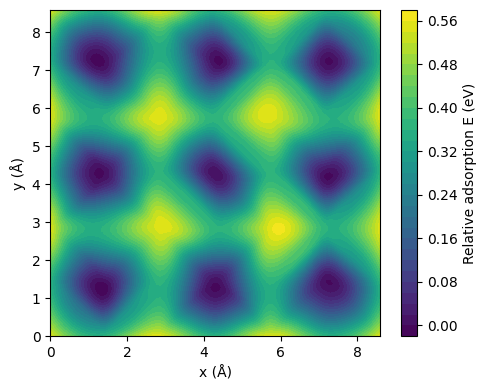

In [70]:
from scipy.interpolate import griddata

xy = np.array(xy_list)
z  = energies.flatten()

# 조밀 격자
xi = np.linspace(xy[:,0].min(), xy[:,0].max(), 100)
yi = np.linspace(xy[:,1].min(), xy[:,1].max(), 100)
XI, YI = np.meshgrid(xi, yi)
ZI = griddata(xy, z, (XI, YI), method='cubic')

plt.figure(figsize=(5,4))
cs = plt.contourf(XI, YI, ZI, levels=30)
plt.colorbar(cs, label='Relative adsorption E (eV)')
plt.xlabel('x (Å)'); plt.ylabel('y (Å)')
plt.tight_layout(); plt.show()

# Bridge relaxation

In [94]:
slab = fcc100('Al', size=(3, 3, 4), periodic=True)
add_adsorbate(slab, 'Au', 2.7, 'bridge')
slab.center(axis=2, vacuum=6.0)

# Fix third and fourth layers:
mask = [atom.tag > 2 for atom in slab]
slab.set_constraint(FixAtoms(mask=mask))

# Relax using EMT potential:
slab.calc = EMT()
qn = LBFGS(slab, trajectory='bridge.traj')
qn.run(fmax=0.05)

       Step     Time          Energy          fmax
LBFGS:    0 14:02:23        8.105304        1.717448
LBFGS:    1 14:02:23        8.044366        1.712102
LBFGS:    2 14:02:23        7.611743        1.331736
LBFGS:    3 14:02:23        7.467655        0.656422
LBFGS:    4 14:02:23        7.452254        0.455895
LBFGS:    5 14:02:23        7.444805        0.365426
LBFGS:    6 14:02:23        7.407752        0.524316
LBFGS:    7 14:02:23        7.380237        0.471216
LBFGS:    8 14:02:23        7.345261        0.188382
LBFGS:    9 14:02:23        7.342238        0.160140
LBFGS:   10 14:02:23        7.332834        0.199069
LBFGS:   11 14:02:23        7.318728        0.305628
LBFGS:   12 14:02:23        7.300457        0.330269
LBFGS:   13 14:02:23        7.288599        0.208630
LBFGS:   14 14:02:23        7.284026        0.125344
LBFGS:   15 14:02:23        7.282467        0.113223
LBFGS:   16 14:02:23        7.280113        0.111588
LBFGS:   17 14:02:23        7.275614        0.15

np.True_

In [95]:
images = ase.io.read('bridge.traj', ':')
ase.io.write('bridge.extxyz', images)

/Users/inwon/anaconda3/lib/python3.11/site-packages/ase/io/extxyz.py:318: UserWarning: Skipping unhashable information adsorbate_info
  warnings.warn('Skipping unhashable information '


# Ontop relaxation

In [60]:
slab = fcc100('Al', size=(3, 3, 4), periodic=True)
add_adsorbate(slab, 'Au', 2.7, 'ontop')
slab.center(axis=2, vacuum=6.0)

# Fix third and fourth layers:
mask = [atom.tag > 2 for atom in slab]
slab.set_constraint(FixAtoms(mask=mask))

# Relax using EMT potential:
slab.calc = EMT()
qn = LBFGS(slab, trajectory='ontop.traj')
qn.run(fmax=0.05)

       Step     Time          Energy          fmax
LBFGS:    0 09:54:40        8.009529        1.565427
LBFGS:    1 09:54:40        7.957476        1.496990
LBFGS:    2 09:54:40        7.747065        0.890903
LBFGS:    3 09:54:40        7.735639        0.493865
LBFGS:    4 09:54:40        7.728383        0.313939
LBFGS:    5 09:54:40        7.722057        0.472927
LBFGS:    6 09:54:40        7.707023        0.684315
LBFGS:    7 09:54:40        7.672080        0.911283
LBFGS:    8 09:54:40        7.627352        0.773707
LBFGS:    9 09:54:40        7.604649        0.326557
LBFGS:   10 09:54:40        7.591053        0.294285
LBFGS:   11 09:54:40        7.578210        0.287169
LBFGS:   12 09:54:40        7.555795        0.480354
LBFGS:   13 09:54:40        7.523555        0.559758
LBFGS:   14 09:54:40        7.493362        0.458715
LBFGS:   15 09:54:40        7.482295        0.202153
LBFGS:   16 09:54:40        7.477511        0.104832
LBFGS:   17 09:54:40        7.476482        0.10

np.True_

In [61]:
images = ase.io.read('ontop.traj', ':')
ase.io.write('ontop.extxyz', images)

# Hollow relaxation

In [62]:
slab = fcc100('Al', size=(3, 3, 4), periodic=True)
add_adsorbate(slab, 'Au', 2.7, 'hollow')
slab.center(axis=2, vacuum=6.0)

# Fix third and fourth layers:
mask = [atom.tag > 2 for atom in slab]
slab.set_constraint(FixAtoms(mask=mask))

# Relax using EMT potential:
slab.calc = EMT()
qn = LBFGS(slab, trajectory='hollow.traj')
qn.run(fmax=0.05)

       Step     Time          Energy          fmax
LBFGS:    0 09:56:00        8.201410        1.753171


LBFGS:    1 09:56:00        8.142561        1.763491
LBFGS:    2 09:56:00        7.681085        1.803837
LBFGS:    3 09:56:00        7.298421        1.379966
LBFGS:    4 09:56:00        7.116190        0.420433
LBFGS:    5 09:56:00        7.106781        0.359388
LBFGS:    6 09:56:00        7.063048        0.399884
LBFGS:    7 09:56:00        6.997018        0.323199
LBFGS:    8 09:56:00        6.963895        0.167401
LBFGS:    9 09:56:00        6.959075        0.125193
LBFGS:   10 09:56:00        6.955888        0.113005
LBFGS:   11 09:56:00        6.949228        0.204283
LBFGS:   12 09:56:00        6.939944        0.274175
LBFGS:   13 09:56:00        6.929320        0.252563
LBFGS:   14 09:56:00        6.922585        0.187234
LBFGS:   15 09:56:00        6.920058        0.188352
LBFGS:   16 09:56:00        6.918833        0.172430
LBFGS:   17 09:56:00        6.916026        0.134241
LBFGS:   18 09:56:00        6.911417        0.143657
LBFGS:   19 09:56:00        6.906284        0.

np.True_

In [63]:
images = ase.io.read('hollow.traj', ':')
ase.io.write('hollow.extxyz', images)

# Training data generation #1: MD perturbation

In [76]:
from ase import Atoms, Atom, units
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md import VelocityVerlet

In [77]:
def generate_data(count, image, filename='training.traj'):
    """Generates test or training data with a simple MD simulation."""
    
    image_copy = image.copy()
    image_copy.calc = EMT()
    image_copy.get_potential_energy()
    
    # Trajectory file
    traj = ase.io.Trajectory(filename, 'w')
    traj.write(image_copy)
    
    MaxwellBoltzmannDistribution(image_copy, 300. * units.kB)
    dyn = VelocityVerlet(image_copy, timestep=1. * units.fs)
    for step in range(count - 1):
        dyn.run(50)
        traj.write(image_copy)

In [79]:
image_copy = ase.io.read('ontop.traj', index="-1")

# 1000 MD perutrbation
generate_data(count=1000, image=image_copy, filename='MD_training.traj') 

/Users/inwon/anaconda3/lib/python3.11/site-packages/ase/md/md.py:54: FutureWarning: Specify the temperature in K using the 'temperature_K' argument
  warnings.warn(FutureWarning(w))


In [80]:
# Save images to xyz trajectory for future visualization
images = ase.io.read('MD_training.traj', ':')
ase.io.write('MD_training.extxyz', images)

/Users/inwon/anaconda3/lib/python3.11/site-packages/ase/io/extxyz.py:318: UserWarning: Skipping unhashable information adsorbate_info
  warnings.warn('Skipping unhashable information '


# Training data generation #2: NEB (use many images)

In [81]:
initial_copy = ase.io.read('hollow.traj')
view(initial_copy, viewer='x3d')

In [83]:
# Final state:
final_copy = initial_copy.copy()
final_copy[-1].x += slab.get_cell()[0, 0] / 4
final_copy.calc = EMT()

qn = LBFGS(final_copy, trajectory='final.traj')
qn.run(fmax=0.05)

       Step     Time          Energy          fmax
LBFGS:    0 13:49:47        7.409613        2.399165
LBFGS:    1 13:49:47        7.271115        1.682014
LBFGS:    2 13:49:47        7.111034        0.551956
LBFGS:    3 13:49:47        7.092238        0.435585
LBFGS:    4 13:49:47        7.082358        0.468946
LBFGS:    5 13:49:47        7.066387        0.564609
LBFGS:    6 13:49:47        7.035564        0.667269
LBFGS:    7 13:49:47        7.005337        0.586578
LBFGS:    8 13:49:47        6.983643        0.376082
LBFGS:    9 13:49:47        6.963860        0.219137
LBFGS:   10 13:49:47        6.959495        0.193073
LBFGS:   11 13:49:47        6.955228        0.204459
LBFGS:   12 13:49:47        6.934481        0.245907
LBFGS:   13 13:49:47        6.925590        0.162342
LBFGS:   14 13:49:47        6.923184        0.088808
LBFGS:   15 13:49:47        6.921813        0.083106
LBFGS:   16 13:49:47        6.919617        0.100922
LBFGS:   17 13:49:47        6.916089        0.12

np.True_

In [84]:
view(final_copy, viewer='x3d')

In [85]:
constraint = FixAtoms(mask=[atom.tag > 2 for atom in initial_copy])

images = [initial_copy]

for i in range(13):
    
    image = initial_copy.copy()
    image.calc = EMT()
    image.set_constraint(constraint)
    images.append(image)

images.append(final_copy)

In [86]:
neb = NEB(images)
neb.interpolate(method='idpp')

qn = LBFGS(neb, trajectory='NEB_training_hbh.traj')
qn.run(fmax=0.05)

       Step     Time          Energy          fmax
LBFGS:    0 13:50:38        7.864033        3.738341
LBFGS:    1 13:50:38        7.546701        2.288557
LBFGS:    2 13:50:38        7.304891        0.462243
LBFGS:    3 13:50:38        7.291898        0.248103
LBFGS:    4 13:50:38        7.290966        0.240697
LBFGS:    5 13:50:38        7.288310        0.242979
LBFGS:    6 13:50:38        7.279987        0.260026
LBFGS:    7 13:50:38        7.271286        0.312860
LBFGS:    8 13:50:38        7.270018        0.270031
LBFGS:    9 13:50:38        7.271176        0.176009
LBFGS:   10 13:50:38        7.270171        0.158391
LBFGS:   11 13:50:38        7.267087        0.109171
LBFGS:   12 13:50:38        7.265409        0.122387
LBFGS:   13 13:50:38        7.265579        0.109744
LBFGS:   14 13:50:38        7.265641        0.134638
LBFGS:   15 13:50:39        7.264901        0.120399
LBFGS:   16 13:50:39        7.263785        0.086158
LBFGS:   17 13:50:39        7.263580        0.06

np.True_

In [87]:
# Save images to xyz trajectory for future visualization
images = ase.io.read('NEB_training_hbh.traj', ':')
ase.io.write('NEB_training_hbh.extxyz', images)

/Users/inwon/anaconda3/lib/python3.11/site-packages/ase/io/extxyz.py:318: UserWarning: Skipping unhashable information adsorbate_info
  warnings.warn('Skipping unhashable information '


In [88]:
# Final state:
final_copy = initial_copy.copy()
final_copy[-1].x += slab.get_cell()[0, 0] / 4
final_copy[-1].y += slab.get_cell()[1, 1] / 4
final_copy.calc = EMT()

qn = LBFGS(final_copy, trajectory='final.traj')
qn.run(fmax=0.05)

       Step     Time          Energy          fmax
LBFGS:    0 13:51:22        8.878912        8.910914
LBFGS:    1 13:51:22        7.531512        2.726740
LBFGS:    2 13:51:22        7.315169        1.259738
LBFGS:    3 13:51:22        7.233976        0.602362
LBFGS:    4 13:51:22        7.209727        0.526701
LBFGS:    5 13:51:22        7.189109        0.590750
LBFGS:    6 13:51:22        7.158078        0.688278
LBFGS:    7 13:51:22        7.120333        0.693783
LBFGS:    8 13:51:22        7.095261        0.558859
LBFGS:    9 13:51:22        7.075969        0.364756
LBFGS:   10 13:51:22        7.057341        0.271991
LBFGS:   11 13:51:22        7.050947        0.322449
LBFGS:   12 13:51:22        7.032170        0.424431
LBFGS:   13 13:51:22        6.992755        0.485907
LBFGS:   14 13:51:22        6.964164        0.331325
LBFGS:   15 13:51:22        6.956104        0.219544
LBFGS:   16 13:51:22        6.947024        0.211594
LBFGS:   17 13:51:22        6.942291        0.24

np.True_

In [89]:
view(final_copy, viewer='x3d')

In [90]:
constraint = FixAtoms(mask=[atom.tag > 2 for atom in initial_copy])

images = [initial_copy]

for i in range(13):
    
    image = initial_copy.copy()
    image.calc = EMT()
    image.set_constraint(constraint)
    images.append(image)

images.append(final_copy)

In [91]:
neb = NEB(images)
neb.interpolate(method='idpp')

qn = LBFGS(neb, trajectory='NEB_training_hoh.traj')
qn.run(fmax=0.05)

       Step     Time          Energy          fmax
LBFGS:    0 13:52:15        7.792897        2.432769
LBFGS:    1 13:52:15        7.668610        1.456592
LBFGS:    2 13:52:15        7.586393        0.526178
LBFGS:    3 13:52:15        7.576149        0.359980
LBFGS:    4 13:52:15        7.567620        0.372654
LBFGS:    5 13:52:15        7.553692        0.502887
LBFGS:    6 13:52:15        7.535469        0.531222
LBFGS:    7 13:52:15        7.523741        0.398675
LBFGS:    8 13:52:15        7.520112        0.280762
LBFGS:    9 13:52:15        7.517957        0.355383
LBFGS:   10 13:52:15        7.513299        0.343551
LBFGS:   11 13:52:15        7.504710        0.295208
LBFGS:   12 13:52:15        7.498525        0.276608
LBFGS:   13 13:52:15        7.495400        0.264803
LBFGS:   14 13:52:15        7.492373        0.274938
LBFGS:   15 13:52:15        7.487693        0.213665
LBFGS:   16 13:52:15        7.483401        0.131899
LBFGS:   17 13:52:15        7.481595        0.18

np.True_

In [92]:
# Save images to xyz trajectory for future visualization
images = ase.io.read('NEB_training_hoh.traj', ':')
ase.io.write('NEB_training_hoh.extxyz', images)

/Users/inwon/anaconda3/lib/python3.11/site-packages/ase/io/extxyz.py:318: UserWarning: Skipping unhashable information adsorbate_info
  warnings.warn('Skipping unhashable information '


# Merge data

In [96]:
# hollow.traj 에서 모든 프레임
images_hollow = ase.io.read('hollow.traj', ':')
print(f"hollow frames: {len(images_hollow)}")

# ontop.traj 에서 모든 프레임
images_ontop = ase.io.read('ontop.traj', ':')
print(f"ontop frames: {len(images_ontop)}")

# bridge.traj 에서 모든 프레임
images_bridge = ase.io.read('bridge.traj', ':')
print(f"bridge frames: {len(images_bridge)}")

# MD_training.traj 에서 모든 프레임
images_md = ase.io.read('MD_training.traj', ':')
print(f"MD frames: {len(images_md)}")

# NEB_training.traj 에서 모든 프레임
images_neb_hbh = ase.io.read('NEB_training_hbh.traj', ':')
print(f"NEB h-b-h frames: {len(images_neb_hbh)}")

# NEB_training.traj 에서 모든 프레임
images_neb_hoh = ase.io.read('NEB_training_hoh.traj', ':')
print(f"NEB h-o-h frames: {len(images_neb_hoh)}")

hollow frames: 23
ontop frames: 23
bridge frames: 21
MD frames: 1000
NEB h-b-h frames: 285
NEB h-o-h frames: 660


In [97]:
# 첫번째 training data: MD only
images_all = images_hollow + images_ontop + images_bridge + images_md
print(f"Training 1 frames: {len(images_all)}")

ase.io.write('training_set_1.traj', images_all)
ase.io.write('training_set_1.extxyz', images_all)

Training 1 frames: 1067


/Users/inwon/anaconda3/lib/python3.11/site-packages/ase/io/extxyz.py:318: UserWarning: Skipping unhashable information adsorbate_info
  warnings.warn('Skipping unhashable information '


In [98]:
# 두번째 training data: MD + NEB
idx = list(range(len(images_md)))
np.random.shuffle(idx)

images_md_selected = [images_md[i] for i in idx[:600]]
images_all = images_hollow + images_ontop + images_bridge + images_md_selected + images_neb_hbh[-200:] + images_neb_hoh[-200:]
print(f"Training 2 frames: {len(images_all)}")

ase.io.write('training_set_2.traj', images_all)
ase.io.write('training_set_2.extxyz', images_all) 

Training 2 frames: 1067


/Users/inwon/anaconda3/lib/python3.11/site-packages/ase/io/extxyz.py:318: UserWarning: Skipping unhashable information adsorbate_info
  warnings.warn('Skipping unhashable information '
